Question 1

The final weight vector w is: (0.3605313423455556,0.9369255428515546)


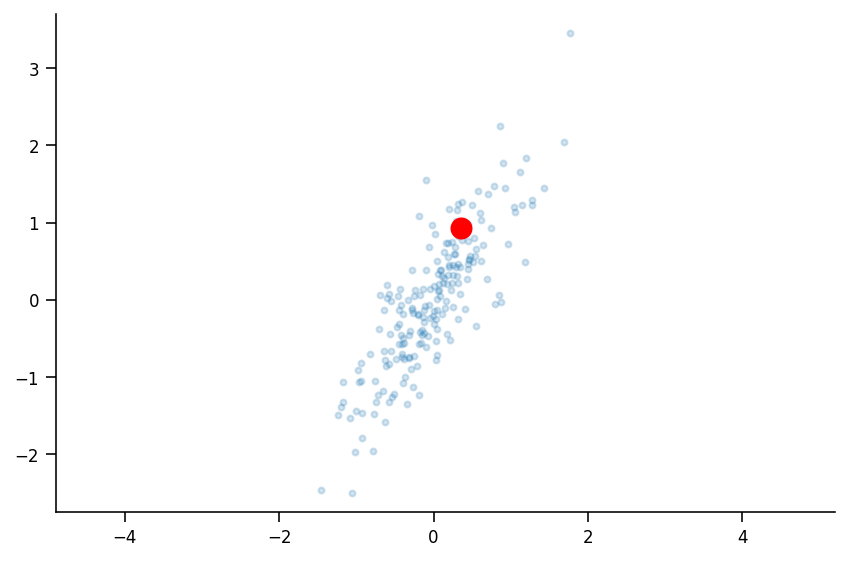

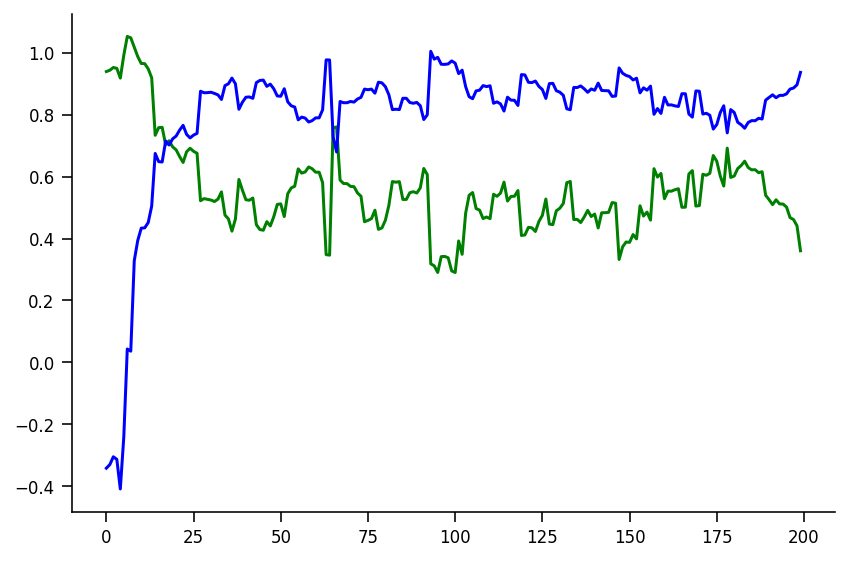

In [ ]:
%matplotlib inline  
import neurodynex3.ojas_rule.oja as oja
import matplotlib.pyplot as plt

cloud = oja.make_cloud(n=200, ratio=.3, angle=60)
wcourse = oja.learn(cloud, initial_angle=-20, eta=0.2)
plt.scatter(cloud[:, 0], cloud[:, 1], marker=".", alpha=.2)
plt.plot(wcourse[-1, 0], wcourse[-1, 1], "or", markersize=10)
plt.axis('equal')
plt.figure()
plt.plot(wcourse[:, 0], "g")
plt.plot(wcourse[:, 1], "b")
print("The final weight vector w is: ({},{})".format(wcourse[-1,0],wcourse[-1,1]))

In [49]:
# Imports
import numpy as np
import matplotlib.pyplot as plt

# @title Figure Settings
import ipywidgets as widgets  # interactive display
%config InlineBackend.figure_format = 'retina'
# use NMA plot style
plt.style.use("https://raw.githubusercontent.com/NeuromatchAcademy/course-content/NMA2020/nma.mplstyle")
my_layout = widgets.Layout()

def default_pars(**kwargs):
  pars = {}

  # typical neuron parameters#
  pars['V_th'] = 1.     # spike threshold [mV]
  pars['V_reset'] = 0.  # reset potential [mV]
  pars['tau_m'] = 10.     # membrane time constant [ms]
  pars['g_L'] = 10.       # leak conductance [nS]
  pars['V_init'] = 0.   # initial potential [mV]
  pars['E_L'] = 0.      # leak reversal potential [mV]
  pars['tref'] = 2.       # refractory time (ms)

  # simulation parameters #
  pars['T'] = 200.  # Total duration of simulation [ms]
  pars['dt'] = .1   # Simulation time step [ms]

  # external parameters if any #
  for k in kwargs:
    pars[k] = kwargs[k]

  pars['range_t'] = np.arange(0, pars['T'], pars['dt'])  # Vector of discretized time points [ms]

  return pars


pars = default_pars()


def plot_volt_trace(pars, v, sp):
  """
  Plot trajetory of membrane potential for a single neuron

  Expects:
  pars   : parameter dictionary
  v      : volt trajetory
  sp     : spike train

  Returns:
  figure of the membrane potential trajetory for a single neuron
  """
  V_th = pars['V_th']
  dt, range_t = pars['dt'], pars['range_t']
  if sp.size:
    sp_num = (sp / dt).astype(int) - 1
    v[sp_num] += 20  # draw nicer spikes

  plt.plot(pars['range_t'], v, 'b')
  plt.axhline(V_th, 0, 1, color='k', ls='--')
  plt.xlabel('Time (ms)')
  plt.ylabel('V (mV)')
  plt.legend(['Membrane\npotential', r'Threshold V$_{\mathrm{th}}$'],
             loc=[1.05, 0.75])
  plt.ylim([-0.5,2.1])


def plot_GWN(pars, I_GWN):
  """
  Args:
    pars  : parameter dictionary
    I_GWN : Gaussian white noise input

  Returns:
    figure of the gaussian white noise input
  """

  plt.figure(figsize=(12, 4))
  plt.subplot(121)
  plt.plot(pars['range_t'][::3], I_GWN[::3], 'b')
  plt.xlabel('Time (ms)')
  plt.ylabel(r'$I_{GWN}$ (pA)')
  plt.subplot(122)
  plot_volt_trace(pars, v, sp)
  plt.tight_layout()


def my_hists(isi1, isi2, cv1, cv2, sigma1, sigma2):
  """
  Args:
    isi1 : vector with inter-spike intervals
    isi2 : vector with inter-spike intervals
    cv1  : coefficient of variation for isi1
    cv2  : coefficient of variation for isi2

  Returns:
    figure with two histograms, isi1, isi2

  """
  plt.figure(figsize=(11, 4))
  my_bins = np.linspace(10, 30, 20)
  plt.subplot(121)
  plt.hist(isi1, bins=my_bins, color='b', alpha=0.5)
  plt.xlabel('ISI (ms)')
  plt.ylabel('count')
  plt.title(r'$\sigma_{GWN}=$%.1f, CV$_{\mathrm{isi}}$=%.3f' % (sigma1, cv1))

  plt.subplot(122)
  plt.hist(isi2, bins=my_bins, color='b', alpha=0.5)
  plt.xlabel('ISI (ms)')
  plt.ylabel('count')
  plt.title(r'$\sigma_{GWN}=$%.1f, CV$_{\mathrm{isi}}$=%.3f' % (sigma2, cv2))
  plt.tight_layout()
  plt.show()


# the function plot the raster of the Poisson spike train
def my_raster_Poisson(range_t, spike_train, n):
  """
  Generates poisson trains

  Args:
    range_t     : time sequence
    spike_train : binary spike trains, with shape (N, Lt)
    n           : number of Poisson trains plot

  Returns:
    Raster plot of the spike train
  """

  # find the number of all the spike trains
  N = spike_train.shape[0]

  # n should smaller than N:
  if n > N:
    print('The number n exceeds the size of spike trains')
    print('The number n is set to be the size of spike trains')
    n = N

  # plot rater
  i = 0
  while i < n:
    if spike_train[i, :].sum() > 0.:
      t_sp = range_t[spike_train[i, :] > 0.5]  # spike times
      plt.plot(t_sp, i * np.ones(len(t_sp)), 'k|', ms=10, markeredgewidth=2)
    i += 1
  plt.xlim([range_t[0], range_t[-1]])
  plt.ylim([-0.5, n + 0.5])
  plt.xlabel('Time (ms)', fontsize=12)
  plt.ylabel('Neuron ID', fontsize=12)
# solution of exercise
def run_LIF_sol(pars, Iinj, stop=False):
  """
  Simulate the LIF dynamics with external input current
  Args:
    pars       : parameter dictionary
    Iinj       : input current [pA]. The injected current here can be a value
                 or an array
    stop       : boolean. If True, use a current pulse
  Returns:
    rec_v      : membrane potential
    rec_sp     : spike times
  """
  # Set parameters
  V_th, V_reset = pars['V_th'], pars['V_reset']
  tau_m, g_L = pars['tau_m'], pars['g_L']
  V_init, E_L = pars['V_init'], pars['E_L']
  dt, range_t = pars['dt'], pars['range_t']
  Lt = range_t.size
  tref = pars['tref']

  # Initialize voltage and current
  v = np.zeros(Lt)
  v[0] = V_init
  Iinj = Iinj * np.ones(Lt)
  if stop:  # set end of current to 0 if current pulse
    Iinj[:int(len(Iinj) / 2) - 1000] = 0
    Iinj[int(len(Iinj) / 2) + 1000:] = 0
  tr = 0.  # the count for refractory duration

  # Simulate the LIF dynamics
  rec_spikes = []  # record spike times
  for it in range(Lt - 1):
    if tr > 0:  # check for refractoriness
      v[it] = V_reset
      tr = tr - 1
    elif v[it] >= V_th:  # reset voltage and record spike event
      rec_spikes.append(it)
      v[it] = V_reset
      tr = tref / dt

    # calculate the increment of the membrane potential
    dv = (-(v[it] - E_L) + Iinj[it] / g_L) * (dt / tau_m)

    # update the membrane potential
    v[it + 1] = v[it] + dv

  rec_spikes = np.array(rec_spikes) * dt

  return v, rec_spikes

def my_GWN(pars, mu, sig, myseed=False):
  """
  Function that generates Gaussian white noise input

  Args:
    pars       : parameter dictionary
    mu         : noise baseline (mean)
    sig        : noise amplitute (standard deviation)
    myseed     : random seed. int or boolean
                 the same seed will give the same
                 random number sequence

  Returns:
    I          : Gaussian white noise input
  """

  # Retrieve simulation parameters
  dt, range_t = pars['dt'], pars['range_t']
  Lt = range_t.size

  # set random seed
  # you can fix the seed of the random number generator so that the results
  # are reliable however, when you want to generate multiple realization
  # make sure that you change the seed for each new realization.
  if myseed:
      np.random.seed(seed=myseed)
  else:
      np.random.seed()

  # generate GWN
  # we divide here by 1000 to convert units to sec.
  I_gwn = mu + sig * np.random.randn(Lt) / np.sqrt(dt / 1000.)

  return I_gwn


from numpy import *
from pylab import *
from numpy import random

def train2binned(train,dt,smboxsize):
    if train.shape[0]==0:
        smrate = zeros(train.shape[1])
    else:
        rate = mean(train,axis=0)/dt
        nbins = floor(float(int(len(rate)))/smboxsize)
        smrate = rate[:int(nbins*smboxsize)].reshape((int(nbins),smboxsize))
        smrate = array([mean(smrate,axis=1)])
        smrate = smrate.repeat(smboxsize,axis=0)
        smrate = transpose(smrate).reshape(int(nbins*smboxsize),1)
        smrate = append(smrate,ones(len(rate)-int(nbins*smboxsize))*mean(rate[int(nbins*smboxsize):]))
    return smrate

w = array([1,-.1,-.1,1])

Question 2A


L 2000
u0 (2000,)
frate (2000,)
range_t 2000


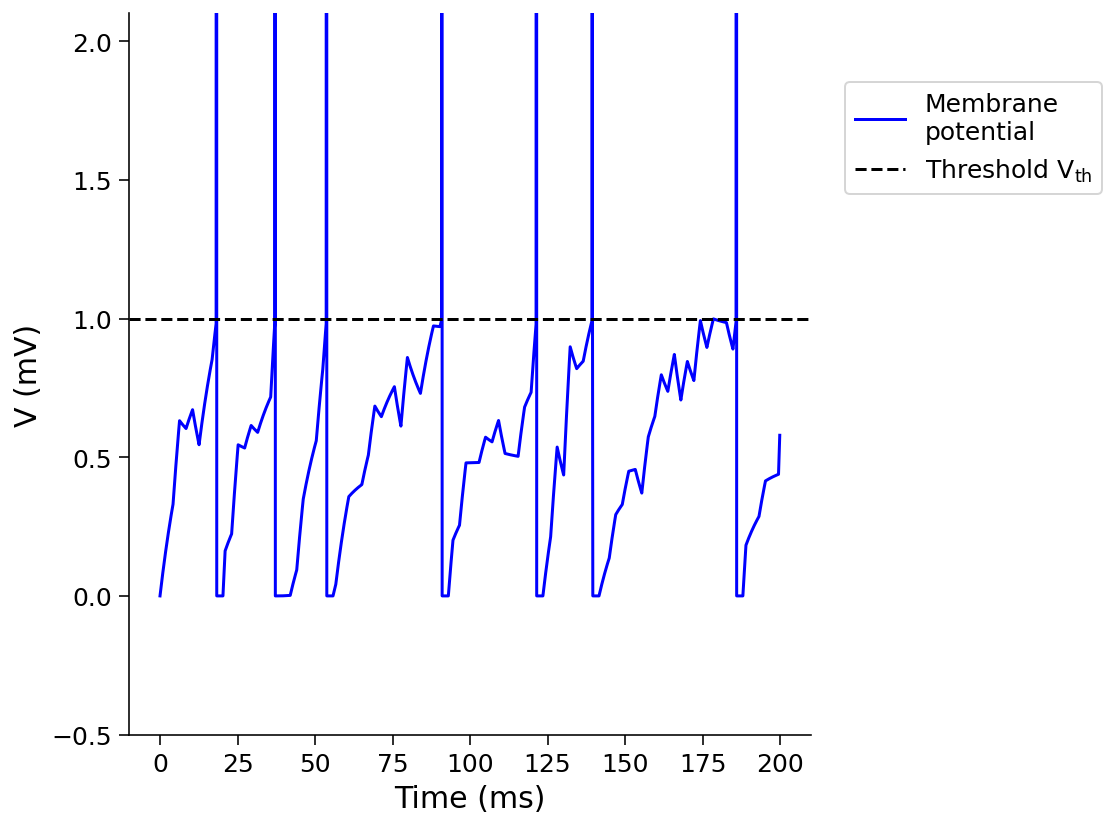

In [76]:
pars = default_pars(T=200)  # get the parameters
pars['tau_m']= 10.0
I0 = 0.8
w0 = 0.1
tau_m = 10.0
v0 = 1000.

inh_rate = (ones(2000)*10) #inputrate in Hz
dt = 0.01 # ms per bin
L = len(inh_rate)

nrep = 1000
spktr = zeros((nrep,L),dtype = bool)
randmat = rand(nrep,L)
for t in range(L):
				rho = inh_rate[t]  
				pspike = rho*dt*1e-3
				spktr[:,t] = randmat[:,t] < pspike
frate = train2binned(spktr,dt,smboxsize=21)*1e3

u0 = I0*(1- np.exp(-1./tau_m)) + (w0 * tau_m * frate)

print('L', L)
print('u0',u0.shape)
print('frate',frate.shape)
print('range_t', pars['range_t'].size)

v, sp = run_LIF_sol(pars, Iinj=u0)

plot_volt_trace(pars, v, sp)


Question 2B


L 2000
u0 (2000,)
frate (2000,)
range_t 2000


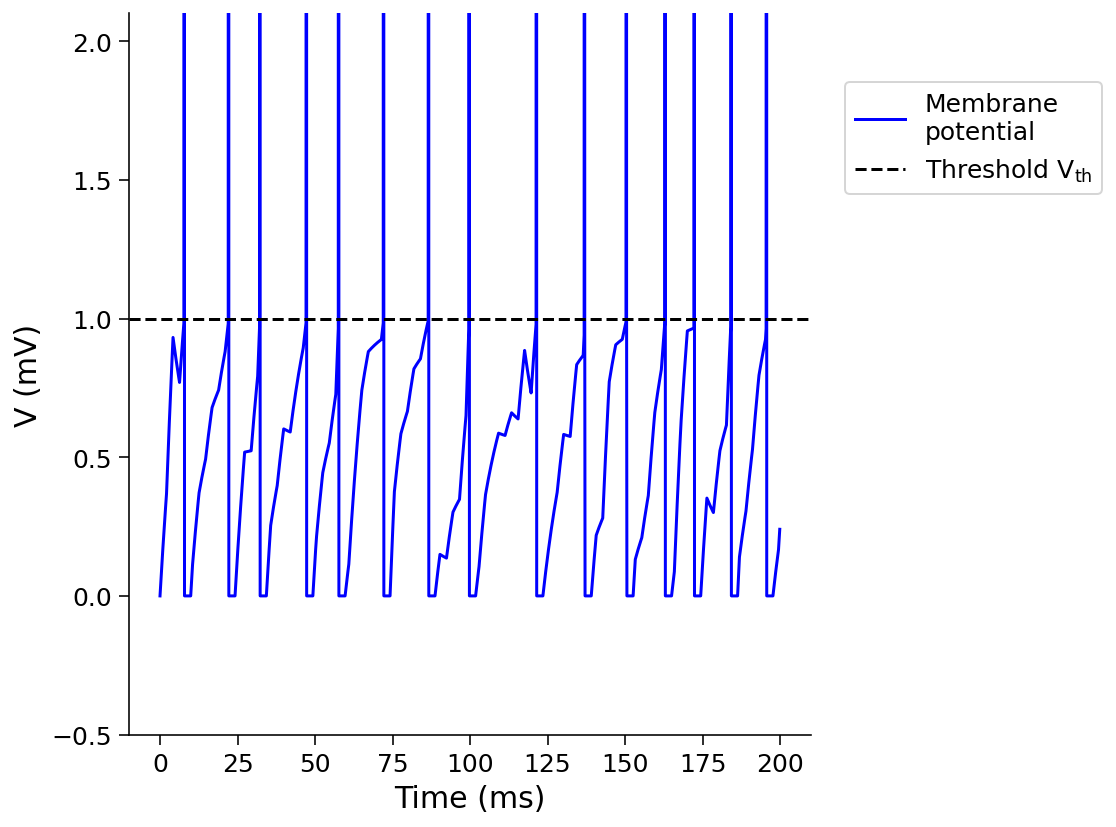

In [75]:
pars = default_pars(T=200)  # get the parameters
pars['tau_m']= 10.0
I0 = 0.8
w0 = 0.025
tau_m = 10.0

inh_rate = (ones(2000)*16) #inputrate in Hz
dt = 0.01 # ms per bin
L = len(inh_rate)

nrep = 1000
spktr = zeros((nrep,L),dtype = bool)
randmat = rand(nrep,L)
for t in range(L):
				rho = inh_rate[t]  
				pspike = rho*dt*1e-3
				spktr[:,t] = randmat[:,t] < pspike
frate = train2binned(spktr,dt,smboxsize=21)*1e3

u0 = I0*(1- np.exp(-1./tau_m)) + (w0 * tau_m * frate)
delta_u = (-u0/tau_m) + frate + I0

print('L', L)
print('u0',u0.shape)
print('frate',frate.shape)
print('range_t', pars['range_t'].size)

v, sp = run_LIF_sol(pars, Iinj=delta_u)

plot_volt_trace(pars, v, sp)


Question 3A

In [ ]:
data = [([1,2,3],0),([1,3,2],0), ([1,3,6],0), ([1,5,3],0), ([1,5.5,4.5],0),([1,5,6],1), ([1,7,4],1), ([1,8,6],1), ([1,9,7],1), ([1,9.5,5],1)]
n = len(data)
golden_error = 2 * 0.05
num_batches_run = 0
current_error = 0
l_r = 0.1

w = np.array([0.1, 0.1, 0.1])

while True:
  sum_gradient = 0
  sum_error = 0
  for x,t in data:
    x = np.array(x)
    y = 1./(1 + np.exp(sum(w*(-x))))
    error = (t-y)
    gradient = -error * x
    sum_gradient += gradient
    sum_error += error
  w = w - (l_r * sum_gradient)
  current_error = abs(sum_error)/n
  num_batches_run += 1
  print(num_batches_run, current_error, w)
  if current_error < golden_error:
    break
## It took 27 batches for error to go less than 0.1
## The final values of w are [-3.14726813  3.27631775 -1.92010213]

1 0.2508653309245822 [-0.15086533 -0.48120216 -0.67576585]
2 0.4888043310172474 [0.337939   3.33513278 2.09335469]
3 0.4999997816140761 [-0.16206078  1.48513326  0.2433553 ]
4 0.4959642206399087 [-0.658025   -0.35544902 -1.59435378]
5 0.4989690204683441 [-0.15905598  3.49147431  1.20325961]
6 0.49999675658386 [-0.65905274  1.6414811  -0.64673095]
7 0.4177624206909421 [-1.07681516  0.01166455 -2.12519819]
8 0.4993673515618628 [-0.57744781  3.85965976  0.67339022]
9 0.4999890431105197 [-1.07743685  2.00968214 -1.17657726]
10 0.32531589356460605 [-1.40275274  0.64874459 -2.20173371]
11 0.496377490948658 [-0.90637525  4.48351489  0.58863144]
12 0.49999448010786873 [-1.40636973  2.63352605 -1.26135208]
13 0.37394718454033543 [-1.78031692  1.11680124 -2.50688513]
14 0.49008225160299856 [-1.29023467  4.90902567  0.2595376 ]
15 0.49999079931602813 [-1.79022547  3.05904418 -1.5904348 ]
16 0.3460827486871554 [-2.13630821  1.61374953 -2.70563495]
17 0.4248609773570631 [-1.71144724  4.87911563 -0.

Question 3B


In [ ]:
data = [([1,2,3],0),([1,3,2],0), ([1,3,6],0), ([1,5,3],0), ([1,5.5,4.5],0),([1,5,6],1), ([1,7,4],1), ([1,8,6],1), ([1,9,7],1), ([1,9.5,5],1)]
n = len(data)
golden_error = 2 * 0.05
num_batches_run = 0
current_error = 0
l_r = 0.1
alpha = 1.

w = np.array([0.1, 0.1, 0.1])

while True:
  sum_gradient = 0
  sum_error = 0
  for x,t in data:
    x = np.array(x)
    regularizer = alpha * (0.5 * sum(w**2))
    y = 1./(1 + np.exp(sum(w*(-x)))) + regularizer
    error = (t-y)
    gradient = -error * x
    sum_gradient += gradient
    sum_error += error
  w = w - (l_r * sum_gradient)
  current_error = abs(sum_error)/n
  num_batches_run += 1
  print(num_batches_run, current_error, w)
  if current_error < golden_error:
    break
  if num_batches_run > 1000:
    break  

#   When alpha = 0.01, it takes 29 extra batches for a new total of 56 batches for our loss to decrease under 0.1, 
#  w is [-6.55203995  3.98656831 -4.22950248]
#   When alpha = 1, it takes 25 less batches for a new total of 2 batches for our loss to decrease under 0.1
#  w is [-0.12528836  0.68488954 -0.06763276]



1 0.2658653309245822 [-0.16586533 -0.56670216 -0.74551585]
2 0.040576974767576476 [-0.12528836  0.68488954 -0.06763276]
